# Entrenamiento modelo videomae para LSC

## Importar las dependencias necesarias

In [4]:
from pathlib import Path

import torch
from transformers import Trainer, TrainingArguments, DefaultDataCollator, EarlyStoppingCallback
from datasets import DatasetDict, load_from_disk 

import config
# from train.optuna import objective
from data.load import load_video_metadata, create_label_mappings
from data.datasets import build_huggingface_dataset
from data.preprocesing import create_map_function
from model.load import load_model, load_image_processor
from training.metrics import compute_metrics

## Verificar si se cuenta con tarjeta grafica compatible con CUDA

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



## PASO 1: Cargar Rutas y crear Metadata

In [20]:
# Definir la ruta base
base_dataset_path = Path("../dataset")
# Cargar datos de cada split
# --- PASO 1: Cargar Metadatos ---
base_dataset_path = Path("../dataset")
video_metadata = load_video_metadata(base_dataset_path)

--- Cargando Metadatos desde: ..\dataset ---
  Procesando: ..\dataset\train...
    -> 220 videos cargados.
  Procesando: ..\dataset\eval...
    -> 48 videos cargados.
  Procesando: ..\dataset\test...
    -> 58 videos cargados.
Metadatos cargados para 326 videos.


## PASO 2: Crear Mapeos y construir DatasetDict

In [21]:
label2id, id2label = create_label_mappings(video_metadata)
raw_dataset = build_huggingface_dataset(video_metadata, label2id)

print("\n--- Dataset Crudo Cargado ---")
print(raw_dataset)


--- Creando Mapeos de Etiquetas ---
Se crearon mapeos para 10 clases.
¡DatasetDict construido!

--- Dataset Crudo Cargado ---
DatasetDict({
    train: Dataset({
        features: ['video_path', 'label'],
        num_rows: 220
    })
    validation: Dataset({
        features: ['video_path', 'label'],
        num_rows: 48
    })
    test: Dataset({
        features: ['video_path', 'label'],
        num_rows: 58
    })
})


## PASO 3: Cargar Modelo e Image Processor

In [22]:
model = load_model(
    model_ckpt=config.MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    device=device,
    freeze_base=True,
    unfreeze_last_n=3
)
image_processor = load_image_processor(
    model_ckpt=config.PROCCESSOR
)

Unique classes: ['ABUELO', 'ADIOS', 'BIEN', 'COMER', 'COMO_ESTAS', 'HAMBRE', 'HOLA', 'NINA', 'NINO', 'POR_FAVOR'].


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freezing base layers except the last 3 encoder layers...
Model moved to device: cuda


## PASO 4: Aplicando Preprocesamiento (PyAV + Aug Avanzada)

In [9]:
height = width = image_processor.size["shortest_edge"]
resize_to = (height, width)
num_frames_to_sample = model.config.num_frames

processed_dataset_path = Path("./processed_sign_language_dataset")

if processed_dataset_path.exists():
    print(f"Cargando 'processed_dataset' desde el disco: {processed_dataset_path}")
    processed_dataset = load_from_disk(str(processed_dataset_path))
    # Es importante volver a establecer el formato después de cargar desde disco
    processed_dataset.set_format("torch")
    print("'processed_dataset' cargado.")
else:
    train_map_fn = create_map_function(image_processor, num_frames_to_sample, resize_to, is_train=True)
    val_test_map_fn = create_map_function(image_processor, num_frames_to_sample, resize_to, is_train=False)

    # Aplicar .map() - ESTO ES LO QUE CREA EL CONTENIDO DEL NUEVO DATASET
    processed_dataset = DatasetDict({
        'train': raw_dataset['train'].map(train_map_fn, remove_columns=['video_path'], batched=False), # Quitamos path y label_str
        'validation': raw_dataset['validation'].map(val_test_map_fn, remove_columns=['video_path'], batched=False),
        'test': raw_dataset['test'].map(val_test_map_fn, remove_columns=['video_path'], batched=False),
    })
    
    processed_dataset = processed_dataset.filter(
        lambda x: x['pixel_values'] is not None
    )
    print("Filtrado completado.")
    processed_dataset.save_to_disk(str(processed_dataset_path))
    # Establecer formato PyTorch
    processed_dataset.set_format("torch")

Cargando 'processed_dataset' desde el disco: processed_sign_language_dataset
'processed_dataset' cargado.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..1.7685405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.2979523].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].
Clipping input

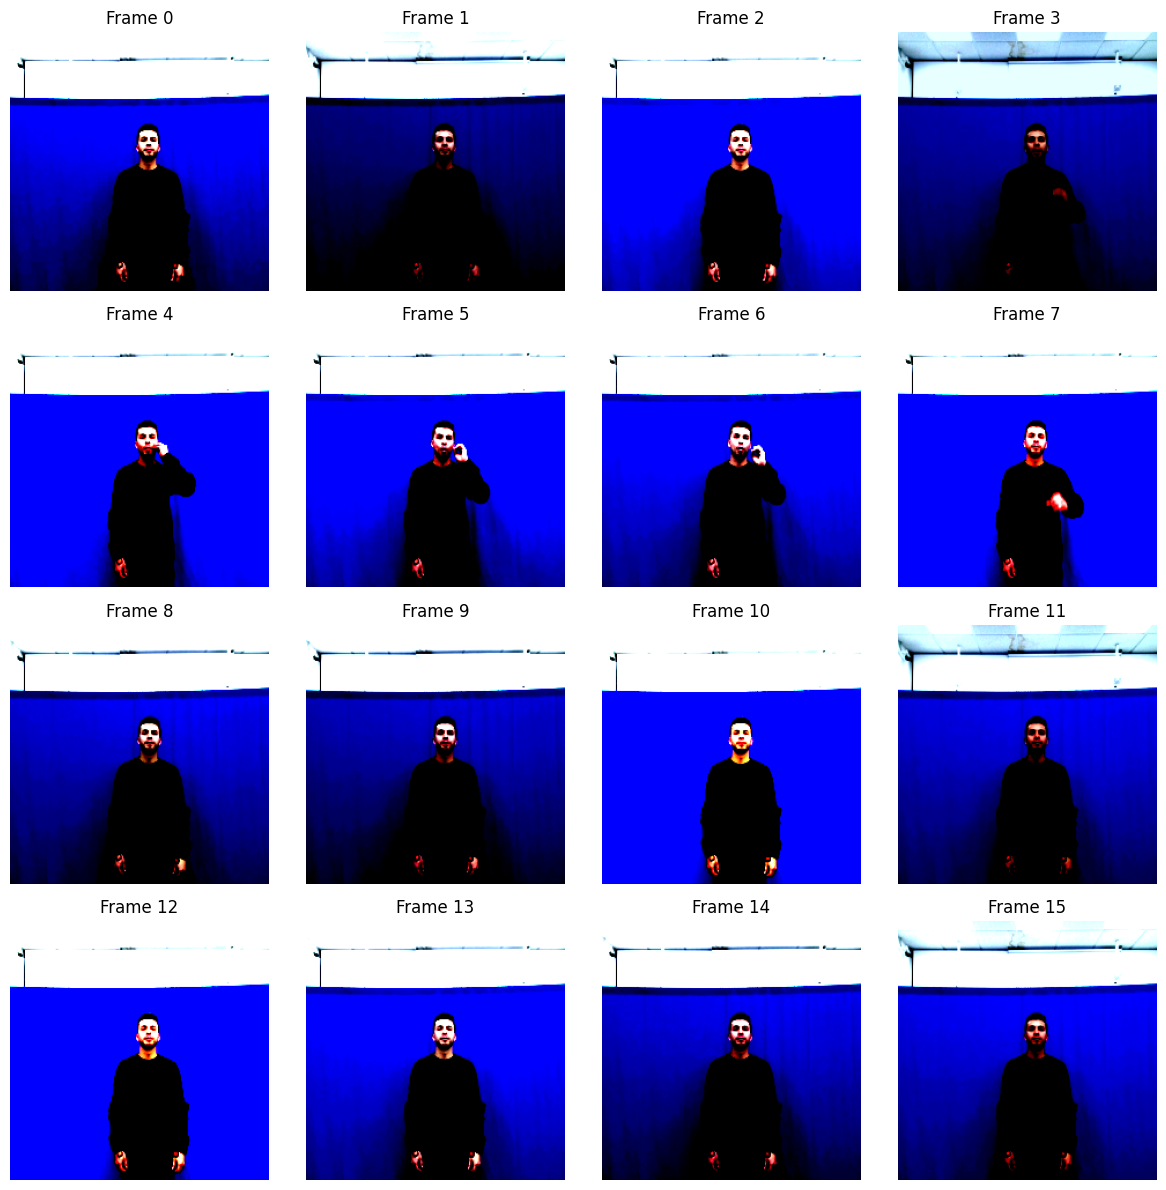

In [10]:
import matplotlib.pyplot as plt

def show_video_frames(pixel_values, n=16, rows=4, cols=4):
    n = min(n, len(pixel_values))
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        frame = pixel_values[i].permute(1, 2, 0).cpu().numpy()
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f'Frame {i}')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
example = processed_dataset['train'][0]
show_video_frames(example['pixel_values'], n=16, rows=4, cols=4)

## PASO 5: Configurar el Entrenamiento

In [11]:
output_dir = "./results/videomae-LSC-finetuned"
learning_rate = 4.9610155578982295e-05 
batch_size = 4
num_epochs = 24 

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.013320764183634398,         
    
    # Estrategias de Evaluación y Guardado
    eval_strategy="epoch",    # Evaluar al final de cada época
    save_strategy="epoch",          # Guardar al final de cada época
    load_best_model_at_end=True,    # Cargar el mejor modelo al final
    save_total_limit=2,             # Guardar solo los 2 últimos/mejores checkpoints
    metric_for_best_model="f1_weighted",
    greater_is_better=True,         # Mejor si el F1 ponderado es mayor
    # Logging y Otros
    logging_dir=f"{output_dir}/logs",
    logging_steps=10,               # Cada cuántos pasos mostrar logs
    remove_unused_columns=False,    # Importante si tu dataset tiene columnas extra
    fp16=torch.cuda.is_available(), # Usar precisión mixta si hay GPU (acelera y ahorra VRAM)
    # Early stopping
    # Opcional: Para Optuna más adelante
    # report_to="none", # Podrías cambiarlo a 'wandb' o 'tensorboard'
)

data_collator = DefaultDataCollator()

trainer = Trainer(
    model=model,             
    args=training_args,                
    train_dataset=processed_dataset["train"], 
    eval_dataset=processed_dataset["validation"], 
    tokenizer=image_processor,         
    compute_metrics=compute_metrics,
    data_collator=data_collator,   
    callbacks=[EarlyStoppingCallback(
            early_stopping_patience=3,        # <-- aquí va la paciencia
            early_stopping_threshold=0.0      # <-- aquí el delta mínimo de mejora
        )]
)

C:\Users\danie\AppData\Local\Temp\ipykernel_18768\1834741429.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## PASO 6: Iniciando Entrenamiento

In [9]:
try:
    # Lanza el proceso de entrenamiento
    train_results = trainer.train()

    print("\n--- Entrenamiento Finalizado ---")

    # Guarda el mejor modelo encontrado durante el entrenamiento
    print("Guardando el mejor modelo...")
    trainer.save_model()

    # Guarda las métricas del entrenamiento
    print("Guardando métricas de entrenamiento...")
    trainer.log_metrics("train", train_results.metrics)
    trainer.save_metrics("train", train_results.metrics)

    # Guarda el estado del Trainer (útil para reanudar)
    trainer.save_state()
    print("Métricas y estado del Trainer guardados.")

except Exception as e:
    print(f"\nOcurrió un error durante el entrenamiento: {e}")
    print("Revisa los mensajes de error anteriores.")
    print("Posibles causas: Memoria VRAM/RAM insuficiente (reduce 'batch_size'),")
    print("problemas con los datos, configuración incorrecta o errores de CUDA.")

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted
1,2.267000,2.146118,0.333333,0.303571,0.310268,0.454848,0.469634,0.330000,0.333333
2,1.086900,1.057620,0.770833,0.732118,0.735093,0.760833,0.768576,0.775000,0.770833
3,0.561700,0.481662,0.916667,0.911421,0.913022,0.926667,0.927778,0.915000,0.916667
4,0.226000,0.317139,0.916667,0.908283,0.915572,0.933333,0.937500,0.910000,0.916667
5,0.038100,0.250700,0.937500,0.937637,0.938015,0.962500,0.960938,0.935000,0.937500
6,0.045600,0.202298,0.958333,0.956623,0.957792,0.963333,0.961806,0.955000,0.958333
7,0.007400,0.188759,0.958333,0.956623,0.957792,0.963333,0.961806,0.955000,0.958333
8,0.004300,0.213728,0.958333,0.956623,0.957792,0.963333,0.961806,0.955000,0.958333
9,0.003300,0.213449,0.958333,0.956623,0.957792,0.963333,0.961806,0.955000,0.958333


c:\Users\danie\Documents\TFM\training_models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\Documents\TFM\training_models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danie\Documents\TFM\training_models\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi


--- Entrenamiento Finalizado ---
Guardando el mejor modelo...
Guardando métricas de entrenamiento...
***** train metrics *****
  epoch                    =          9.0
  total_flos               = 2297930336GF
  train_loss               =       0.5301
  train_runtime            =   0:07:28.52
  train_samples_per_second =       11.772
  train_steps_per_second   =        2.943
Métricas y estado del Trainer guardados.


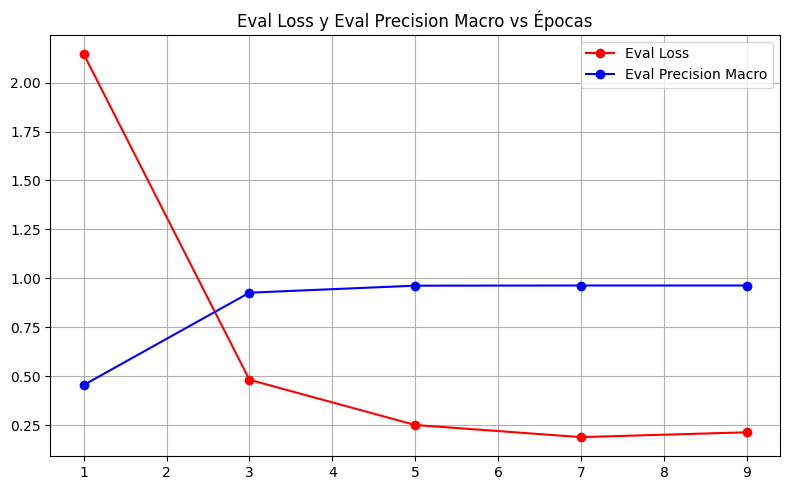

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Lee el archivo trainer_state.json
with open(r"results\videomae-LSC-finetuned/trainer_state.json") as f:
    state = json.load(f)

# Extrae los logs de entrenamiento
train_logs = state['log_history']

epochs = []
eval_losses = []
eval_precisions = []

for entry in train_logs:
    if 'epoch' in entry:
        epoch = entry['epoch']
        if epoch not in epochs:
            epochs.append(epoch)
            eval_losses.append(entry.get('eval_loss', None))
            eval_precisions.append(entry.get('eval_precision_macro', None))

# Convertir a numpy arrays y filtrar None/NaN
epochs = np.array(epochs)
eval_losses = np.array(eval_losses, dtype=np.float64)
eval_precisions = np.array(eval_precisions, dtype=np.float64)

mask = (~np.isnan(eval_losses)) & (~np.isnan(eval_precisions))
epochs_clean = epochs[mask]
eval_losses_clean = eval_losses[mask]
eval_precisions_clean = eval_precisions[mask]

# Graficar en el mismo eje y
plt.figure(figsize=(8, 5))
plt.plot(epochs_clean, eval_losses_clean, marker='o', linestyle='-', color='red', label='Eval Loss')
plt.plot(epochs_clean, eval_precisions_clean, marker='o', linestyle='-', color='blue', label='Eval Precision Macro')

#plt.ylim(0, 1.6)  # Ajusta este rango si tus valores lo requieren
plt.legend()
plt.title('Eval Loss y Eval Precision Macro vs Épocas')
plt.grid(True)
plt.tight_layout()
plt.show()

## PASO 7: Testear el modelo

C:\Users\danie\AppData\Local\Temp\ipykernel_16636\2258593915.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  test_trainer = Trainer(


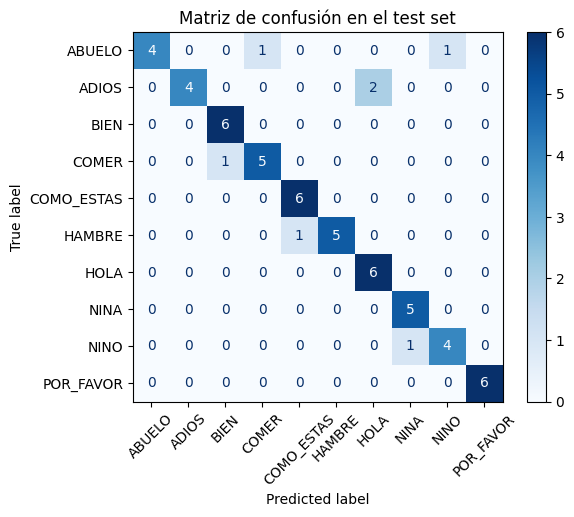

In [12]:
from transformers import VideoMAEForVideoClassification # El modelo que usas (ej: AutoModelForImageClassification)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = VideoMAEForVideoClassification.from_pretrained(r"results\videomae-LSC-finetuned",)

# Prepara el Trainer solo para evaluación
test_trainer = Trainer(
    model=model,    
    args=training_args,  # Puedes reusar los mismos argumentos, ajustando output_dir si quieres
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    eval_dataset=processed_dataset["test"]
)

pred_output = test_trainer.predict(processed_dataset["test"])
y_true = pred_output.label_ids
y_pred = pred_output.predictions.argmax(axis=1)  # Si es clasificación multiclase


cm = confusion_matrix(y_true, y_pred)

class_names = [id2label[i] for i in range(len(id2label))]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión en el test set")
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 (macro y weighted)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Precision Macro:   {precision_macro:.4f}")
print(f"Precision Weighted:{precision_weighted:.4f}")
print(f"Recall Macro:      {recall_macro:.4f}")
print(f"Recall Weighted:   {recall_weighted:.4f}")
print(f"F1 Macro:          {f1_macro:.4f}")
print(f"F1 Weighted:       {f1_weighted:.4f}")

# Classification report con nombres de clase
target_names = [id2label[i] for i in range(len(id2label))]
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

Accuracy: 0.8793
Precision Macro:   0.8931
Precision Weighted:0.8957
Recall Macro:      0.8800
Recall Weighted:   0.8793
F1 Macro:          0.8755
F1 Weighted:       0.8762

Classification Report:
              precision    recall  f1-score   support

      ABUELO       1.00      0.67      0.80         6
       ADIOS       1.00      0.67      0.80         6
        BIEN       0.86      1.00      0.92         6
       COMER       0.83      0.83      0.83         6
  COMO_ESTAS       0.86      1.00      0.92         6
      HAMBRE       1.00      0.83      0.91         6
        HOLA       0.75      1.00      0.86         6
        NINA       0.83      1.00      0.91         5
        NINO       0.80      0.80      0.80         5
   POR_FAVOR       1.00      1.00      1.00         6

    accuracy                           0.88        58
   macro avg       0.89      0.88      0.88        58
weighted avg       0.90      0.88      0.88        58



In [12]:
import torch
from PIL import Image
from transformers import VideoMAEForVideoClassification, VideoMAEImageProcessor
from data.preprocesing import read_and_sample_video_pyav, process_with_hf  # ajusta el import si es necesario

def infer_video_class(video_path: str, model, processor, id2label: dict) -> str:
    # 1. Leer y muestrear frames
    num_frames = model.config.num_frames
    size = (processor.size["shortest_edge"], processor.size["shortest_edge"])
    frames = read_and_sample_video_pyav(video_path, num_frames=num_frames)
    
    if frames is None:
        raise ValueError(f"No se pudieron leer frames del video: {video_path}")

    # 2. Convertir a PIL y redimensionar (si es necesario)
    pil_frames = [Image.fromarray(f).resize(size) for f in frames]

    # 3. Preprocesar
    inputs = processor(pil_frames, return_tensors="pt")

    # 4. Inferencia
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probs = torch.nn.functional.softmax(logits, dim=-1)
    top5_probs, top5_indices = torch.topk(probs, k=5, dim=-1)

    results = []
    for prob, idx in zip(top5_probs[0], top5_indices[0]):
        results.append({
            "label": id2label.get(idx.item(), str(idx.item())),
            "score": round(prob.item(), 4)
        })

    return results

In [ ]:
# Cargar modelo y processor
model = VideoMAEForVideoClassification.from_pretrained(r"results\videomae-LSC-finetuned")
processor = image_processor
print(processor.size)

# Clasificar video
video_path = r"../data_real_scenario\COMO_ESTAS\como_estas1.mp4"
pred_label = infer_video_class(video_path, model, processor, id2label)
print("Predicción:", pred_label)

{'shortest_edge': 224}
Predicción: [{'label': 'COMO_ESTAS', 'score': 0.4788}, {'label': 'BIEN', 'score': 0.1614}, {'label': 'ADIOS', 'score': 0.0902}, {'label': 'COMER', 'score': 0.0565}, {'label': 'POR_FAVOR', 'score': 0.0536}]


In [ ]:
#